# <span style="color:#F72585">Regresion Basica con tf.keras: Predecir eficiencia de la gasolina</span>

## <span style="color:#4361EE">Introducción</span> 

Información general sobre [TensorFlow](https://www.tensorflow.org/?hl=en).

Vea el cuaderno original en: [tensorflow.org](https://www.tensorflow.org/tutorials/keras/regression)

Nuestra comunidad de TensorFlow ha traducido estos documentos. Como las traducciones de la comunidad
son basadas en el "mejor esfuerzo", no hay ninguna garantía que esta sea un reflejo preciso y actual 
de la [documentacion oficial en inglés](https://www.tensorflow.org/?hl=en).
Si tienen sugerencias sobre como mejorar esta traducción, por favor enviar un *pull request*
al siguiente repositorio [tensorflow/docs](https://github.com/tensorflow/docs).

En un problema de *regresión*, buscamos predecir la salida de un valor continuo como la probabilidad de un precio. En contraste en un problema de *clasificación*, buscamos seleccionar una clase de una lista de clases (por ejemplo, en donde una imagen contenga una manzana o una naranja queremos reconocer cual es la fruta en la imagen).

Este cuaderno usa el set de datos clásico [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) y construye un modelo para predecir la eficiencia de vehículos de $1970$ y $1980$. Para hacer esto proveeremos el modelo con una descripción de muchos automóviles de ese periodo. Esta descripción incluye atributos como: cilindros, desplazamiento, potencia y peso.

Este ejemplo usa el API *Sequential* de `tf.keras` , revise [esta guía](https://www.tensorflow.org/guide/keras) para obtener mas detalles.

## <span style="color:#4361EE">Importa librerías requeridas</span>

In [2]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model



print(tf.__version__)

2.8.0


## <span style="color:#4361EE">El conjunto de datos de MPG</span>

El set de datos está disponible de el siguiente repositorio: [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/).

## <span style="color:#4361EE">Lectura de los datos</span>

Primero descargue el set de datos.

In [3]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'/home/kamilo44/.keras/datasets/auto-mpg.data'

Impórtelo usando pandas.

In [4]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


## <span style="color:#4361EE">Preprocesamiento</span>

### <span style="color:#4CC9F0">Detecta datos faltantes y elimina filas</span>


El set de datos contiene algunos valores desconocidos.

In [5]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

Para Mantener este tutorial inicial sencillo eliminemos las siguientes filas.

In [6]:
dataset = dataset.dropna()

### <span style="color:#4CC9F0">Codificación one-hot</span>

La columna de `"Origin"` realmente es categórica, no numérica. Entonces conviértala a un "one-hot":

In [7]:
# retira 'Origin' del dataset y lo entrega. Se recibe en la variable origin
origin = dataset.pop('Origin') 

In [8]:
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


### <span style="color:#4CC9F0">Ejercicio</span>

Investigue como hacer esta codificación one-hot utilizando: `tf.keras.utils.to_categorical`

### <span style="color:#4CC9F0">Dividir los datos en entrenamiento y test</span>


Ahora divida el set de datos en un set de entrenamiento y otro de pruebas.

Usaremos el set de pruebas en la evaluación final de nuestro modelo.

In [9]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [10]:
train_dataset.keys()

Index(['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
       'Acceleration', 'Model Year', 'USA', 'Europe', 'Japan'],
      dtype='object')

### <span style="color:#4CC9F0">Descriptivo de los datos</span>

Revise rápidamente la distribución conjunta de un par de columnas del set de entrenamiento.

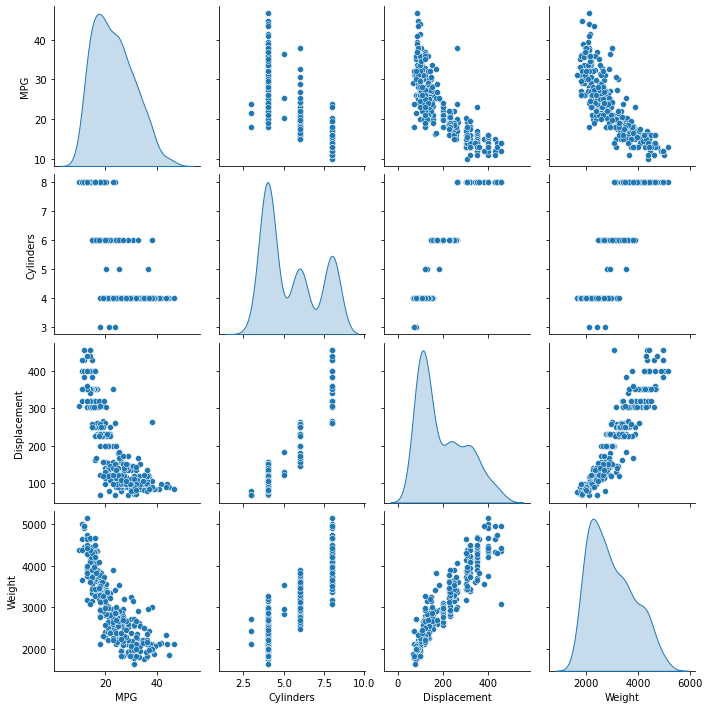

In [11]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

También revise las estadísticas generales:

In [12]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


### <span style="color:#4CC9F0">Separe características y etiquetas</span>

Separe el valor objetivo, o la "etiqueta" de las características. Esta "etiqueta" es el valor que entrenará el modelo para predecir.

In [13]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

### <span style="color:#4CC9F0">Normalice los datos</span>

Revise otra vez el bloque de `train_stats` que se presentó antes y note la diferencia de rangos de cada característica.

Es una buena práctica normalizar funciones que utilizan diferentes escalas y rangos. Aunque el modelo *podría* converger sin normalización de características, dificulta el entrenamiento y hace que el modelo resultante dependa de la elección de las unidades utilizadas en la entrada.

### <span style="color:#4CC9F0">Nota</span>

Aunque generamos intencionalmente estas estadísticas solo del conjunto de datos de entrenamiento, estas estadísticas también se utilizarán para normalizar el conjunto de datos de prueba. Necesitamos hacer eso para proyectar el conjunto de datos de prueba en la misma distribución en la que el modelo ha sido entrenado.

In [14]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

Estos datos normalizados es lo que usaremos para entrenar el modelo.

### <span style="color:#4CC9F0">Precaución</span>

Las estadísticas utilizadas para normalizar las entradas aquí (media y desviación estándar) deben aplicarse a cualquier otro dato que alimente al modelo, junto con la codificación de un punto que hicimos anteriormente. Eso incluye el conjunto de pruebas, así como los datos en vivo cuando el modelo se usa en producción.

## <span style="color:#4361EE">Construye el modelo Sequential modo 1</span>

Construyamos nuestro modelo. Aquí, utilizaremos un modelo `secuencial` con dos capas ocultas densamente conectadas y una capa de salida que devuelve un único valor continuo. Los pasos de construcción del modelo se envuelven en una función, `build_model`, ya que crearemos un segundo modelo, más adelante.

In [16]:
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(normed_train_data.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)])

## <span style="color:#4361EE">Compila</span>

In [17]:
optimizer = tf.keras.optimizers.RMSprop(0.001)
model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])

### <span style="color:#4CC9F0">Summary</span>

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                640       
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


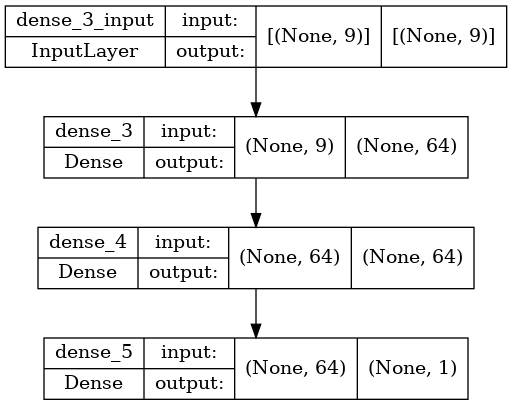

In [18]:
model.summary()
plot_model(model, to_file='../Imagenes/gasolina_model.png', 
           show_shapes=True)

## <span style="color:#4361EE">Entrena</span>

Entrene el modelo durante $1000$ epochs y registre la precisión de entrenamiento y validación en el objeto `history`.

In [19]:
# Muestra el progreso del entrenamiento imprimiendo un solo punto para cada época completada
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

epochs = 1000

history = model.fit(
    normed_train_data, train_labels,
    epochs=epochs, validation_split = 0.2, verbose=0,
    callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

Visualice el progreso de entrenamiento del modelo usando las estadísticas almacenadas en el objeto `history`.

In [20]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.225836,0.960301,2.225836,9.384342,2.317667,9.384342,995
996,2.443506,0.989132,2.443506,9.456791,2.324101,9.456791,996
997,2.218247,0.919126,2.218247,9.429774,2.250995,9.429774,997
998,2.124479,0.982880,2.124479,10.109603,2.452565,10.109603,998
999,2.528567,0.999583,2.528567,9.366143,2.253986,9.366143,999


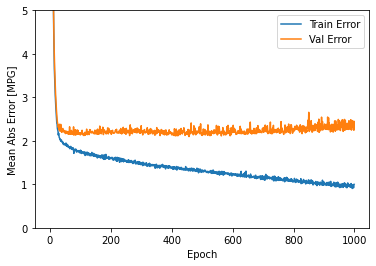

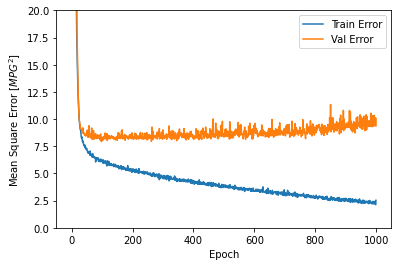

In [21]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

Este gráfico muestra poca mejora, o incluso degradación en el error de validación después de aproximadamente 100 épocas. Actualicemos la llamada `model.fit` para detener automáticamente el entrenamiento cuando el puntaje de validación no mejore. Utilizaremos una *devolución de llamada de EarlyStopping* que pruebe una condición de entrenamiento para cada época. Si transcurre una cantidad determinada de épocas sin mostrar mejoría, entonces detiene automáticamente el entrenamiento.

Puedes obtener más información sobre esta devolución de llamada [aquí](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping).


....................

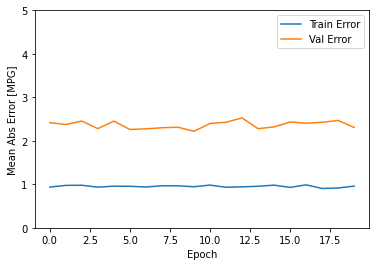

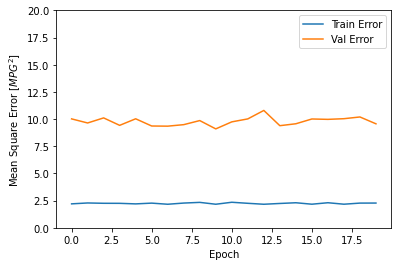

In [22]:
# El parámetro patient es la cantidad de épocas que miden la mejora
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=epochs,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

El gráfico muestra que en el conjunto de validación, el error promedio generalmente es de alrededor de +/- 2 MPG. ¿Es esto bueno? Le dejaremos esa decisión a usted.

Veamos qué tan bien generaliza el modelo al usar el conjunto **test**, que no usamos al entrenar el modelo. Esto nos dice que tan bien podemos esperar que el modelo prediga cuando lo usamos en el mundo real.

In [23]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 7.1032 - mae: 2.1462 - mse: 7.1032 - 29ms/epoch - 10ms/step
Testing set Mean Abs Error:  2.15 MPG


## <span style="color:#4361EE">Predicciones</span>

Finalmente, prediga los valores de MPG utilizando datos en el conjunto de pruebas.

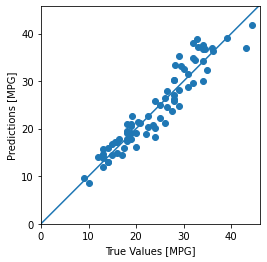

In [24]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


Parece que nuestro modelo predice razonablemente bien. Echemos un vistazo a la distribución de errores.

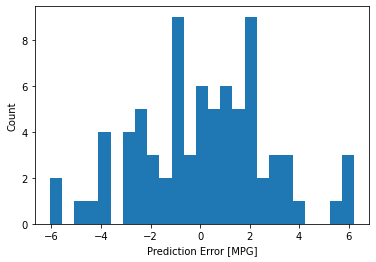

In [25]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

No es del todo gaussiano, pero podríamos esperar eso porque el número de muestras es muy pequeño.

## <span style="color:#4361EE">Conclusión</span>


Este cuaderno introdujo algunas técnicas para manejar un problema de regresión.

* El error cuadrático medio (MSE) es una función de pérdida común utilizada para problemas de regresión (se utilizan diferentes funciones de pérdida para problemas de clasificación).
* Del mismo modo, las métricas de evaluación utilizadas para la regresión difieren de la clasificación. Una métrica de regresión común es el error absoluto medio (MAE).
* Cuando las características de datos de entrada numéricos tienen valores con diferentes rangos, cada característica debe escalarse independientemente al mismo rango.
* Si no hay muchos datos de entrenamiento, una técnica es preferir una red pequeña con pocas capas ocultas para evitar el sobreajuste.
* La detención temprana es una técnica útil para evitar el sobreajuste.